## Install other dependencies

In [1]:
# !pip install -q jupyter_bbox_widget supervision ultralytics open3d matplotlib

### Import the necessary libraries

In [2]:
import torch
import tkinter as tk
from pathlib import Path
from tkinter import filedialog
from IPython.display import display
from tools.utils import display_masked_areas
import open3d as o3d
from tools.orthograohic_image import capture_textured_image_and_depth_from_obj
from tools.extract_and_save_masked_areas import extract_and_save_masked_areas
from tools.generate_topographic_map import generate_topographic_map
from tools.plot_depth_profile_for_mesh import plot_depth_profile_for_mesh
from tools.project_masks_to_3d import project_masks_to_mesh
from tools.process_ply_to_skeleton import process_ply_to_skeleton

from open3d.cuda.pybind.geometry import TriangleMesh
import cv2
import numpy as np

from ultralytics import SAM
import matplotlib.pyplot as plt
import ipywidgets as widgets
from jupyter_bbox_widget import BBoxWidget

from numpy import ndarray
from typing import Union
import base64

# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
MODEL_TYPE = "vit_h"


def load_mesh(filename):
    """ Load a mesh from an OBJ file and return its vertices and normals. """
    mesh: TriangleMesh = o3d.io.read_triangle_mesh(filename)
    if not mesh.has_vertex_normals():
        mesh.compute_vertex_normals()
    vertices = np.asarray(mesh.vertices)
    normals = np.asarray(mesh.vertex_normals)  # Assume normals are already normalized
    return vertices, normals


# helper function that loads an image before adding it to the widget
def encode_image(input: Union[str,ndarray]):
    if isinstance(input, str):     
        with open(input, "rb") as image:
            image_bytes = image.read()
    else:
        image_bytes = cv2.imencode('.jpg', input)[1]
        
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

# Function to open file dialog and get the file path
def select_file():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(filetypes=[("OBJ files", "*.obj")])
    path_widget.value = file_path

# Create a button widget
button_widget = widgets.Button(description="Select .obj file")

# Create a text widget to display the file path
path_widget = widgets.Text(
    value='',
    placeholder='File path will appear here',
    description='File Path:',
    disabled=False
)
# Bind the function to the button click event
button_widget.on_click(lambda b: select_file())

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Load Segment Anything Model 2 (SAM2) with the specified weights
model = SAM("sam2_l.pt")

# Display model information (optional)
model.info()

Model summary: 854 layers, 224,430,130 parameters, 224,430,130 gradients


(854, 224430130, 224430130, 0.0)

## Select the .obj file to segment

In [4]:
# Display the widgets
display(button_widget)
display(path_widget)

Button(description='Select .obj file', style=ButtonStyle())

Text(value='', description='File Path:', placeholder='File path will appear here')

## Capture Textured Orthographic Image and Depth Map

Set the zoom level (default is 0.50), and the number of iterations (default is 1) for Mesh filtering, and use_sharpen (default is True) to use sharpening filter, otherwise False will use smoothing filter

In [11]:
obj_path = path_widget.value
image_path, output_depth_path, camera_params_path = capture_textured_image_and_depth_from_obj(obj_path,zoom=0.40,number_of_iterations=1,use_sharpen=False,strength=0.1)

### Display Orthographic Image

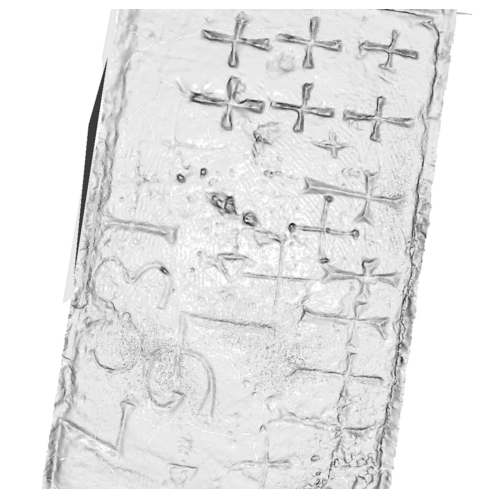

In [12]:
# Load the orthographic image
ortho_image = cv2.imread(image_path,cv2.IMREAD_COLOR)

# Display the orthographic image
plt.imshow(ortho_image)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

### Draw Box

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [13]:
# Create a BBoxWidget
widget = BBoxWidget(classes=['cross'])
widget.image = encode_image(image_path)

# Set resolution of the image
widget.width = ortho_image.shape[1]
widget.height = ortho_image.shape[0]

# Display the widget
widget
### Get Bounding Boxes

BBoxWidget(classes=['cross'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377…

In [14]:
# Get the bounding boxes
boxes = []
for box in widget.bboxes:
    boxes.append(np.array([
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']]))
    
# Print the box coordinates
boxes

[array([406,   4, 559, 130]),
 array([567,  16, 716, 132]),
 array([741,  37, 877, 136]),
 array([378, 143, 545, 261]),
 array([551, 152, 695, 266]),
 array([708, 176, 871, 292]),
 array([619, 330, 847, 464]),
 array([656, 525, 837, 628])]

### Generate masks using SAM2 model

In [15]:
# Generate masks using SAM2
all_masks = model(image_path, bboxes=boxes)


image 1/1 /mobileye/RPT/users/kfirs/kfir_project/MSC_Project/images/brick3_ortho.png: 1024x1024 6753.4ms
Speed: 4.3ms preprocess, 6753.4ms inference, 13.7ms postprocess per image at shape (1, 3, 1024, 1024)


### Display the masks

In [16]:
for mask in all_masks:
    mask.show()

### Save the masks and mask colors

In [17]:
# Generate random mask colors
mask_colors = np.random.randint(100, 255, (len(all_masks[0]), 3))

# Convert the masks to numpy arrays
all_masks = all_masks[0].masks.data.cpu().numpy()

# Save the masks and mask colors the same folder as the image with a prefix
masks_path = image_path.replace(".png", "_masks.npy")
colors_path = image_path.replace(".png", "_colors.npy")
np.save(masks_path, all_masks)
np.save(colors_path, mask_colors)

# Display the paths to the saved masks and colors
masks_path, colors_path

('./images/brick3_ortho_masks.npy', './images/brick3_ortho_colors.npy')

### Project the masks to the 3D mesh

In [18]:
# Apply the masks to the mesh
masked_point_cloud = project_masks_to_mesh(obj_path, masks_path, colors_path, camera_params_path, output_depth_path)

Processing non-masked areas: 100%|██████████| 1008409/1008409 [00:12<00:00, 80745.27pixel/s]
Assigning colors to mesh vertices: 384439vertex [00:04, 83815.62vertex/s]


### Extract and save the masked areas as a 3D mesh separately

In [19]:
# from pathlib import Path

output_dir = Path('datasets') 
label = Path(obj_path).stem
### Extract the 3D masked mesh from the masked point cloud
masks_folders_list:list = extract_and_save_masked_areas(masked_point_cloud, output_dir,label)

Saved masked area 0 with color [    0.39608     0.76863     0.67451] to datasets/brick3_mask_0/mask.ply
Saved masked area 1 with color [    0.56863     0.86275     0.49412] to datasets/brick3_mask_1/mask.ply
Saved masked area 2 with color [    0.57647     0.67843     0.47059] to datasets/brick3_mask_2/mask.ply
Saved masked area 3 with color [        0.6     0.40392     0.47451] to datasets/brick3_mask_3/mask.ply
Saved masked area 4 with color [    0.67451     0.87843     0.65882] to datasets/brick3_mask_4/mask.ply
Saved masked area 5 with color [    0.69804     0.65882     0.84706] to datasets/brick3_mask_5/mask.ply
Saved masked area 6 with color [    0.77647     0.90196     0.63529] to datasets/brick3_mask_6/mask.ply
Saved masked area 7 with color [    0.96471     0.52157     0.43922] to datasets/brick3_mask_7/mask.ply
Finished extracting and saving all masked areas.


### Display the masked areas

In [20]:
for masked_area_folder in masks_folders_list:
    display_masked_areas(masked_area_folder)

Displayed 1 masked areas.
Displayed 1 masked areas.
Displayed 1 masked areas.
Displayed 1 masked areas.
Displayed 1 masked areas.
Displayed 1 masked areas.
Displayed 1 masked areas.
Displayed 1 masked areas.


### Generate the topographic map (contour of the masked areas)

In [21]:
for masked_area_folder in masks_folders_list:
    topographic_map_path = generate_topographic_map(masked_area_folder, num_contours=5, num_iterations=4,mode='equal')

### Generate the depth profile for the meshed areas

In [22]:
for masked_area_folder in masks_folders_list:
    plot_depth_profile_for_mesh(masked_area_folder)

### Extract cross skeleton

In [23]:
for masked_area_folder in masks_folders_list:
    process_ply_to_skeleton(masked_area_folder,project_on_mesh=False)

Skeleton image saved at: datasets/brick3_mask_0/skeleton.png
Skeleton image saved at: datasets/brick3_mask_1/skeleton.png
Skeleton image saved at: datasets/brick3_mask_2/skeleton.png
Skeleton image saved at: datasets/brick3_mask_3/skeleton.png
Skeleton image saved at: datasets/brick3_mask_4/skeleton.png
Skeleton image saved at: datasets/brick3_mask_5/skeleton.png
Skeleton image saved at: datasets/brick3_mask_6/skeleton.png
Skeleton image saved at: datasets/brick3_mask_7/skeleton.png


# TODO
1. Find a way to extract the cross skeleton 
2.  Check contour extraction - should be closed
3.  find  a way to count the number fo closed contours
4. Contours in different depth depths - relative and absolute 
5. clustering based on features